In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

- `yfinance` docs: https://github.com/ranaroussi/yfinance
- What is `SPY`? See here: https://finance.yahoo.com/quote/SPY/

### Get Data

In [2]:
df_spy = yf.download('SPY')

[*********************100%%**********************]  1 of 1 completed


In [3]:
df_spy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,24.840679,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.017357,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.070374,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.335369,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.441366,531500


In [4]:
df_spy.to_csv('SPY.csv', index=True)

In [5]:
df_spy.reset_index(inplace=True)
df_spy['n_trend'] = df_spy.index + 1

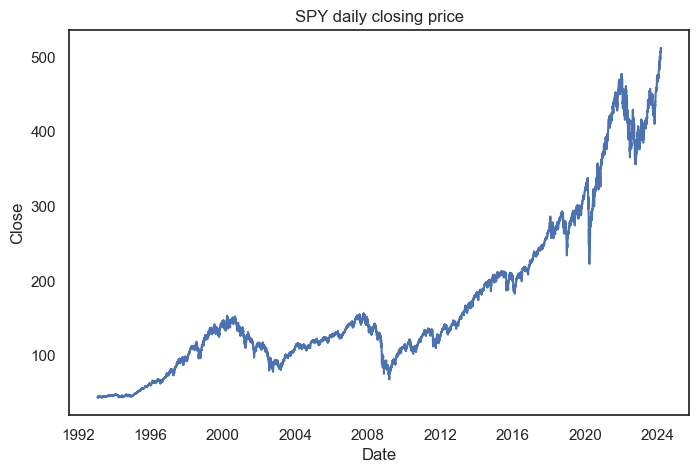

In [6]:
sns.set(style="white")
close_plot, ax1 = plt.subplots(figsize=(8,5))
close_fig = sns.lineplot(
    data = df_spy,
    x = 'Date', y = 'Close')
close_fig.set(title='SPY daily closing price')
close_plot.show()

In [7]:
# create the y variable
df_spy['next_day_close'] = df_spy['Close'].shift(-1)

df_spy['Date_ts'] = pd.to_datetime(df_spy['Date'])
df_spy['n_year'], df_spy['f_month'], df_spy['f_day_of_week'], df_spy['f_week_of_year'] = df_spy['Date_ts'].apply(lambda x: x.year), df_spy['Date_ts'].apply(lambda x: x.month), df_spy['Date_ts'].apply(lambda x: x.dayofweek), df_spy['Date_ts'].apply(lambda x: x.weekofyear)

df_spy['n_closing_price_diff'] = (df_spy['Close'] / df_spy['Close'].shift(1)) - 1
df_spy['n_closing_price_diff'] = df_spy['n_closing_price_diff'].fillna(0)

df_spy['next_day_closing_price_diff'] = (df_spy['Close'].shift(-1) / df_spy['Close']) - 1
df_spy['next_day_closing_price_diff'] = df_spy['next_day_closing_price_diff'].fillna(0)

# drop the last day as there's no actual price
df_spy = df_spy.iloc[:-1]

# rename vars
df_spy.rename(columns={
    'Open': 'n_open',
    'High': 'n_high',
    'Low': 'n_low',
    'Close': 'n_close',
    'Adj Close': 'n_adj_close',
    'Volume': 'n_volume'
}, inplace=True)

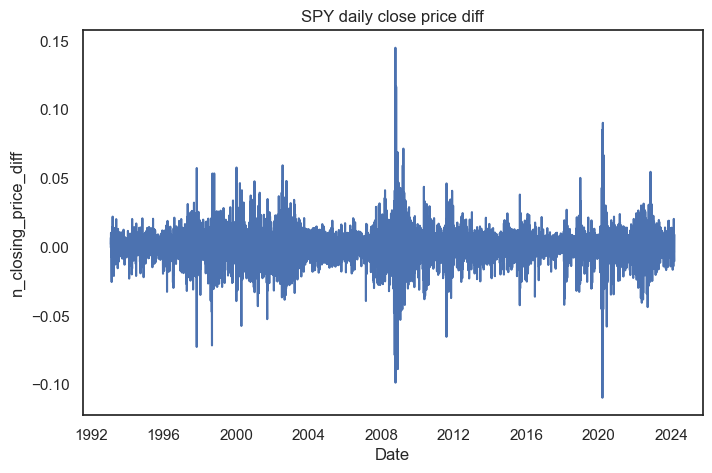

In [8]:
sns.set(style="white")
close_diff_plot, ax3 = plt.subplots(figsize=(8,5))
closs_diff_fig = sns.lineplot(
    data = df_spy,
    x = 'Date', y = 'n_closing_price_diff')
closs_diff_fig.set(title='SPY daily close price diff')
close_diff_plot.show()

<Axes: xlabel='f_day_of_week', ylabel='f_month'>

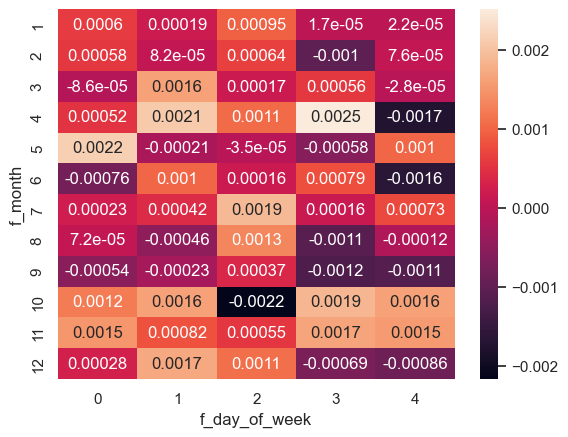

In [9]:
sns.set(style="white")
close_diff_heatmap_data = df_spy.pivot_table(index='f_month', columns='f_day_of_week', values='n_closing_price_diff', aggfunc='mean')
close_diff_heatmap = sns.heatmap(close_diff_heatmap_data, annot = True, 
    # which colormap do you prefer?
    # cmap = 'turbo',
    # cmap = 'coolwarm'
)
close_diff_heatmap

In [10]:
# split data for train, test and holdout
cut_off_year = 2022
holdout_set = df_spy[(df_spy.n_year > cut_off_year)]
training_set = df_spy[(df_spy.n_year <= cut_off_year)]

In [11]:
# create the list of categorical and numerical column names
categorical_columns = [col for col in df_spy.columns if col.startswith("f_")]
numerical_columns = [col for col in df_spy.columns if col.startswith("n_") or col.startswith("d_")]
df_spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7830 entries, 0 to 7829
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         7830 non-null   datetime64[ns]
 1   n_open                       7830 non-null   float64       
 2   n_high                       7830 non-null   float64       
 3   n_low                        7830 non-null   float64       
 4   n_close                      7830 non-null   float64       
 5   n_adj_close                  7830 non-null   float64       
 6   n_volume                     7830 non-null   int64         
 7   n_trend                      7830 non-null   int64         
 8   next_day_close               7830 non-null   float64       
 9   Date_ts                      7830 non-null   datetime64[ns]
 10  n_year                       7830 non-null   int64         
 11  f_month                      7830 non-null 

Custom time series splits [Custom TS Split](https://stackoverflow.com/questions/62210221/walk-forward-with-validation-window-for-time-series-data-cross-validation)

### Modelling & Prediction

#### Modelling

In [12]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

class TimeSeriesSplitCustom(TimeSeriesSplit):
    def __init__(self, n_splits=5, max_train_size=None,
                 test_size=1,
                 min_train_size=1):
        super().__init__(n_splits=n_splits, max_train_size=max_train_size)
        self.test_size = test_size
        self.min_train_size = min_train_size

    def split(self, X, y=None, groups=None):
        min_train_size = self.min_train_size
        test_size = self.test_size

        n_splits = self.n_splits
        n_samples = _num_samples(X)

        if (n_samples - min_train_size) / test_size >= n_splits:
            print('(n_samples -  min_train_size) / test_size >= n_splits')
            print('default TimeSeriesSplit.split() used')
            yield from super().split(X)

        else:
            shift = int(np.floor(
                (n_samples - test_size - min_train_size) / (n_splits - 1)))

            start_test = n_samples - (n_splits * shift + test_size - shift)

            test_starts = range(start_test, n_samples - test_size + 1, shift)

            if start_test < min_train_size:
                raise ValueError(
                    ("The start of the testing : {0} is smaller"
                     " than the minimum training samples: {1}.").format(start_test,
                                                                        min_train_size))

            indices = np.arange(n_samples)

            for test_start in test_starts:
                if self.max_train_size and self.max_train_size < test_start:
                    yield (indices[test_start - self.max_train_size:test_start],
                           indices[test_start:test_start + test_size])
                else:
                    yield (indices[:test_start],
                           indices[test_start:test_start + test_size])

In [13]:
df_spy.n_year.value_counts().shape

(32,)

In [14]:
n_splits=(cut_off_year-1993)*4
cv = TimeSeriesSplitCustom(n_splits=n_splits, test_size=20)

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [16]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# build search for RF
tune_grid = {"max_features": [5, 10, 12], "min_samples_leaf": [3, 5, 7]}

rfr = RandomForestRegressor(random_state=42)

rf_search = GridSearchCV(
    rfr,
    tune_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
# create RF pipeline
rf_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_search)], verbose=True
)
# train the RF
start_time = datetime.now()
rf_result = rf_pipe.fit(training_set[numerical_columns + categorical_columns], training_set.next_day_close)
rf_time = datetime.now() - start_time
rf_result

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 116 folds for each of 9 candidates, totalling 1044 fits
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
[CV 1/116] END max_features=5, min_samples_leaf=3;, score=-12.336 total time=   0.6s
[CV 2/116] END max_features=5, min_samples_leaf=3;, score=-12.571 total time=   0.5s
[CV 3/116] END max_features=5, min_samples_leaf=3;, score=-11.311 total time=   0.5s
[CV 4/116] END max_features=5, min_samples_leaf=3;, score=-8.720 total time=   0.5s
[CV 5/116] END max_features=5, min_samples_leaf=3;, score=-11.913 total time=   0.5s
[CV 6/116] END max_features=5, min_samples_leaf=3;, score=-8.127 total time=   0.5s
[CV 7/116] END max_features=5, min_samples_leaf=3;, score=-7.670 total time=   0.5s
[CV 8/116] END max_features=5, min_samples_leaf=3;, score=-10.540 total time=   0.5s
[CV 9/116] END max_features=5, min_samples_leaf=3;, score=-13.502 total time=   0.5s
[CV 10/116] 

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_month', 'f_day_of_week',
                                                   'f_week_of_year']),
                                                 ('num', 'passthrough',
                                                  ['n_open', 'n_high', 'n_low',
                                                   'n_close', 'n_adj_close',
                                                   'n_volume', 'n_trend',
                                                   'n_year',
                                                   'n_closing_price_diff'])])),
                ('regressor',
                 GridSearchCV(cv=TimeSeriesSplitCustom(max_train_size=None, min_train_size=1, n_splits=116,
           test_size=20),
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [5, 10, 12],
                                          'min_samples_leaf': [3, 5, 7]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [17]:
rf_search.best_params_

{'max_features': 12, 'min_samples_leaf': 3}

In [18]:
from sklearn.metrics import mean_squared_error


# build the performance summary table
def get_time_delta(delta):
    return f'{delta.seconds // 60}m{delta.seconds % 60}s'

diagnostic_df = pd.DataFrame({'Model': ['Random Forest'],
                              'Train RMSE': ['{:.4f}'.format(rf_search.best_score_*-1)],
                              'Holdout RMSE': ['{:.4f}'.format(mean_squared_error(rf_pipe.predict(holdout_set[numerical_columns + categorical_columns]), holdout_set.next_day_close, squared=False))],
                              'Training time': [get_time_delta(rf_time)]
                              })
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Random Forest,6.5679,12.2327,14m11s


_____
predict the difference

In [19]:
preprocessing3 = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

# build search for RF
tune_grid3 = {"max_features": [5, 10, 12], "min_samples_leaf": [3, 5, 7]}

rfr3 = RandomForestRegressor(random_state=42)

rf_search3 = GridSearchCV(
    rfr3,
    tune_grid3,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
# create RF pipeline
rf_pipe3 = Pipeline(
    [("preprocess", preprocessing3), ("regressor", rf_search3)], verbose=True
)
# train the RF
start_time = datetime.now()
rf_result3 = rf_pipe3.fit(training_set[numerical_columns + categorical_columns], training_set.next_day_closing_price_diff)
rf_time3 = datetime.now() - start_time
rf_result3

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 116 folds for each of 9 candidates, totalling 1044 fits
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
[CV 1/116] END max_features=5, min_samples_leaf=3;, score=-0.007 total time=   0.6s
[CV 2/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.8s
[CV 3/116] END max_features=5, min_samples_leaf=3;, score=-0.006 total time=   0.6s
[CV 4/116] END max_features=5, min_samples_leaf=3;, score=-0.010 total time=   0.6s
[CV 5/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 6/116] END max_features=5, min_samples_leaf=3;, score=-0.007 total time=   0.7s
[CV 7/116] END max_features=5, min_samples_leaf=3;, score=-0.008 total time=   0.6s
[CV 8/116] END max_features=5, min_samples_leaf=3;, score=-0.006 total time=   0.7s
[CV 9/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.7s
[CV 10/116] END ma

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_month', 'f_day_of_week',
                                                   'f_week_of_year']),
                                                 ('num', 'passthrough',
                                                  ['n_open', 'n_high', 'n_low',
                                                   'n_close', 'n_adj_close',
                                                   'n_volume', 'n_trend',
                                                   'n_year',
                                                   'n_closing_price_diff'])])),
                ('regressor',
                 GridSearchCV(cv=TimeSeriesSplitCustom(max_train_size=None, min_train_size=1, n_splits=116,
           test_size=20),
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [5, 10, 12],
                                          'min_samples_leaf': [3, 5, 7]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [20]:
rf_search3.best_params_

{'max_features': 5, 'min_samples_leaf': 7}

In [21]:
diagnostic_df.loc[len(diagnostic_df.index)] = ['Random Forest to predict diff', '{:.4f}'.format(rf_search3.best_score_*-1), '{:.4f}'.format(mean_squared_error(rf_pipe3.predict(holdout_set[numerical_columns + categorical_columns]) + holdout_set.n_close, holdout_set.next_day_close, squared=False)), get_time_delta(rf_time3)]
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Random Forest,6.5679,12.2327,14m11s
1,Random Forest to predict diff,0.0094,3.5171,19m56s


-----
mean of last 90 days

In [22]:
df_spy['n_avg_90d_open'], df_spy['n_avg_90d_high'], df_spy['n_avg_90d_low'], df_spy['n_avg_90d_close'], df_spy['n_avg_90d_adj_close'], df_spy['n_avg_90d_volume'], df_spy['n_avg_90d_close_diff'] = df_spy.n_open.rolling(window=90, min_periods=1).mean(), df_spy.n_high.rolling(window=90, min_periods=1).mean(), df_spy.n_low.rolling(window=90, min_periods=1).mean(), df_spy.n_close.rolling(window=90, min_periods=1).mean(), df_spy.n_adj_close.rolling(window=90, min_periods=1).mean(), df_spy.n_volume.rolling(window=90, min_periods=1).mean(), df_spy.n_closing_price_diff.rolling(window=90, min_periods=1).mean()

In [23]:
# split data for train, test and holdout
holdout_set = df_spy[(df_spy.n_year > cut_off_year)]
training_set = df_spy[(df_spy.n_year <= cut_off_year)]

In [24]:
df_spy.head()

,Date,n_open,n_high,n_low,n_close,n_adj_close,n_volume,n_trend,next_day_close,Date_ts,...,f_week_of_year,n_closing_price_diff,next_day_closing_price_diff,n_avg_90d_open,n_avg_90d_high,n_avg_90d_low,n_avg_90d_close,n_avg_90d_adj_close,n_avg_90d_volume,n_avg_90d_close_diff
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,24.840679,1003200,1,44.25000,1993-01-29,...,4,0.000000,0.007112,43.968750,43.968750,43.750000,43.937500,24.840679,1.003200e+06,0.000000
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.017357,480500,2,44.34375,1993-02-01,...,5,0.007112,0.002119,43.968750,44.109375,43.859375,44.093750,24.929018,7.418500e+05,0.003556
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.070374,201300,3,44.81250,1993-02-02,...,5,0.002119,0.010571,44.052083,44.197917,43.947917,44.177083,24.976137,5.616667e+05,0.003077
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.335369,529400,4,45.00000,1993-02-03,...,5,0.010571,0.004184,44.140625,44.359375,44.054688,44.335938,25.065945,5.536000e+05,0.004950
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,25.441366,531500,5,44.96875,1993-02-04,...,5,0.004184,-0.000694,44.306250,44.506250,44.137500,44.468750,25.141029,5.491800e+05,0.004797


In [25]:
numerical_columns2 = ['n_avg_90d_open', 'n_avg_90d_high', 'n_avg_90d_low', 'n_avg_90d_close', 'n_avg_90d_adj_close', 'n_avg_90d_volume', 'n_avg_90d_close_diff', 'n_trend', 'n_year']

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# building preprocessing for pipeline
categorical_encoder2 = OneHotEncoder(handle_unknown="ignore")

preprocessing2 = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns2),
    ]
)

# build search for RF
tune_grid2 = {"max_features": [5, 10, 12], "min_samples_leaf": [3, 5, 7]}

rfr2 = RandomForestRegressor(random_state=42)

rf_search2 = GridSearchCV(
    rfr2,
    tune_grid2,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
# create RF pipeline
rf_pipe2 = Pipeline(
    [("preprocess", preprocessing2), ("regressor", rf_search2)], verbose=True
)
# train the RF
start_time = datetime.now()
rf_result2 = rf_pipe2.fit(training_set[numerical_columns2 + categorical_columns], training_set.next_day_close)
rf_time2 = datetime.now() - start_time
rf_result2

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 116 folds for each of 9 candidates, totalling 1044 fits
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
[CV 1/116] END max_features=5, min_samples_leaf=3;, score=-12.668 total time=   0.5s
[CV 2/116] END max_features=5, min_samples_leaf=3;, score=-10.285 total time=   0.5s
[CV 3/116] END max_features=5, min_samples_leaf=3;, score=-10.301 total time=   0.5s
[CV 4/116] END max_features=5, min_samples_leaf=3;, score=-4.466 total time=   0.5s
[CV 5/116] END max_features=5, min_samples_leaf=3;, score=-11.714 total time=   0.5s
[CV 6/116] END max_features=5, min_samples_leaf=3;, score=-7.318 total time=   0.5s
[CV 7/116] END max_features=5, min_samples_leaf=3;, score=-7.753 total time=   0.5s
[CV 8/116] END max_features=5, min_samples_leaf=3;, score=-8.451 total time=   0.5s
[CV 9/116] END max_features=5, min_samples_leaf=3;, score=-13.610 total time=   0.5s
[CV 10/116] E

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_month', 'f_day_of_week',
                                                   'f_week_of_year']),
                                                 ('num', 'passthrough',
                                                  ['n_avg_90d_open',
                                                   'n_avg_90d_high',
                                                   'n_avg_90d_low',
                                                   'n_avg_90d_close',
                                                   'n_avg_90d_adj_close',
                                                   'n_avg_90d_volume',
                                                   'n_avg_90d_close_diff',
                                                   'n_trend', 'n_year'])])),
                ('regressor',
                 GridSearchCV(cv=TimeSeriesSplitCustom(max_train_size=None, min_train_size=1, n_splits=116,
           test_size=20),
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [5, 10, 12],
                                          'min_samples_leaf': [3, 5, 7]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [27]:
rf_search2.best_params_

{'max_features': 12, 'min_samples_leaf': 3}

In [28]:
diagnostic_df.loc[len(diagnostic_df.index)] = ['Random Forest w. avg', '{:.4f}'.format(rf_search2.best_score_*-1), '{:.4f}'.format(mean_squared_error(rf_pipe2.predict(holdout_set[numerical_columns2 + categorical_columns]), holdout_set.next_day_close, squared=False)), get_time_delta(rf_time2)]
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Random Forest,6.5679,12.2327,14m11s
1,Random Forest to predict diff,0.0094,3.5171,19m56s
2,Random Forest w. avg,9.9163,25.9910,13m51s


_____
Predict diff with avg

In [29]:
# build search for RF

rfr4 = RandomForestRegressor(random_state=42)

rf_search4 = GridSearchCV(
    rfr4,
    tune_grid2,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
# create RF pipeline
rf_pipe4 = Pipeline(
    [("preprocess", preprocessing2), ("regressor", rf_search4)], verbose=True
)
# train the RF
start_time = datetime.now()
rf_result4 = rf_pipe4.fit(training_set[numerical_columns2 + categorical_columns], training_set.next_day_closing_price_diff)
rf_time4 = datetime.now() - start_time
rf_result4

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 116 folds for each of 9 candidates, totalling 1044 fits
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
[CV 1/116] END max_features=5, min_samples_leaf=3;, score=-0.007 total time=   0.7s
[CV 2/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 3/116] END max_features=5, min_samples_leaf=3;, score=-0.006 total time=   0.6s
[CV 4/116] END max_features=5, min_samples_leaf=3;, score=-0.010 total time=   0.6s
[CV 5/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 6/116] END max_features=5, min_samples_leaf=3;, score=-0.007 total time=   0.6s
[CV 7/116] END max_features=5, min_samples_leaf=3;, score=-0.008 total time=   0.6s
[CV 8/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 9/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 10/116] END ma

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_month', 'f_day_of_week',
                                                   'f_week_of_year']),
                                                 ('num', 'passthrough',
                                                  ['n_avg_90d_open',
                                                   'n_avg_90d_high',
                                                   'n_avg_90d_low',
                                                   'n_avg_90d_close',
                                                   'n_avg_90d_adj_close',
                                                   'n_avg_90d_volume',
                                                   'n_avg_90d_close_diff',
                                                   'n_trend', 'n_year'])])),
                ('regressor',
                 GridSearchCV(cv=TimeSeriesSplitCustom(max_train_size=None, min_train_size=1, n_splits=116,
           test_size=20),
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [5, 10, 12],
                                          'min_samples_leaf': [3, 5, 7]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [30]:
rf_search4.best_params_

{'max_features': 5, 'min_samples_leaf': 7}

In [31]:
diagnostic_df.loc[len(diagnostic_df.index)] = ['Random Forest w. 90d avg to predict diff', '{:.4f}'.format(rf_search4.best_score_*-1), '{:.4f}'.format(mean_squared_error(rf_pipe4.predict(holdout_set[numerical_columns2 + categorical_columns]) + holdout_set.n_close, holdout_set.next_day_close, squared=False)), get_time_delta(rf_time4)]
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Random Forest,6.5679,12.2327,14m11s
1,Random Forest to predict diff,0.0094,3.5171,19m56s
2,Random Forest w. avg,9.9163,25.9910,13m51s
3,Random Forest w. 90d avg to predict diff,0.0094,3.5169,18m26s


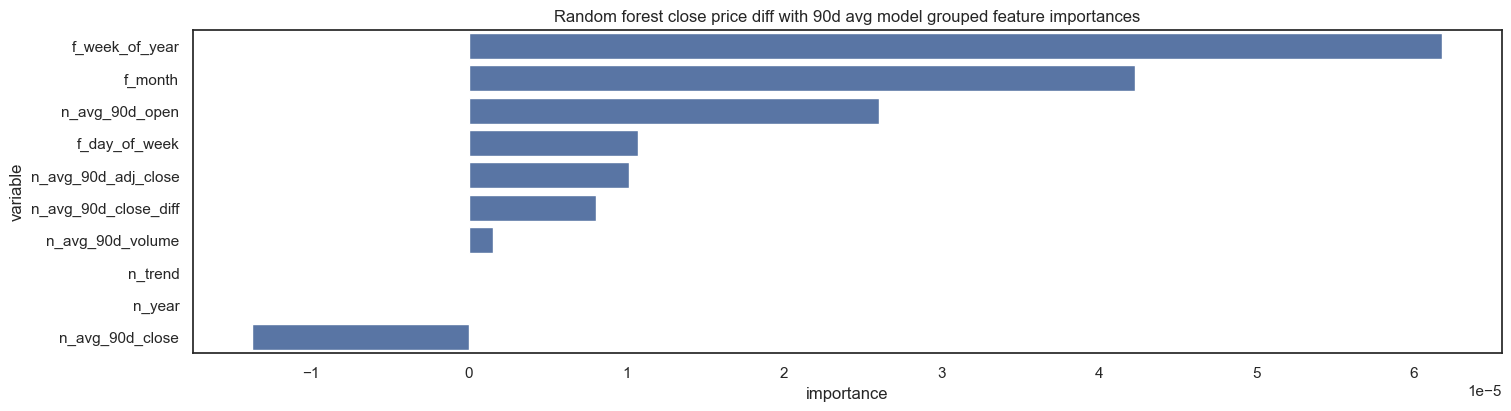

In [32]:
from sklearn.inspection import permutation_importance

# predict with the holdout set and calculate the variable importance for RF
rf_result = permutation_importance(
    rf_pipe4,
    holdout_set[numerical_columns2 + categorical_columns],
    holdout_set.next_day_closing_price_diff,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
df_rf_grouped_var_imp = (pd.DataFrame(
    rf_result.importances_mean,
    numerical_columns2 + categorical_columns)
                         .sort_values(by=0, ascending=False)
                         .reset_index()
                         .rename(columns={'index': 'variable', 0: 'imp'}))
df_rf_grouped_var_imp['cumulative_imp'] = df_rf_grouped_var_imp.imp.cumsum()
df_rf_grouped_var_imp = df_rf_grouped_var_imp.sort_values(by='imp', ascending=False)
sns.set(style="white")
diag_fig, ax1= plt.subplots(figsize=(15,4), layout="constrained")
rf_fig = sns.barplot(
    data = df_rf_grouped_var_imp.iloc[0:10],
    x="imp", y="variable", ax=ax1)
rf_fig.set(title='Random forest close price diff with 90d avg model grouped feature importances', xlabel="importance", ylabel="variable")
diag_fig.show()

_____
TimeSeriesSplit from scikit learn

In [33]:
cv1_norm_ts= TimeSeriesSplit(n_splits=n_splits, test_size=20)

rfr5 = RandomForestRegressor(random_state=42)

rf_search5 = GridSearchCV(
    rfr4,
    tune_grid2,
    cv=cv1_norm_ts,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
# create RF pipeline
rf_pipe5 = Pipeline(
    [("preprocess", preprocessing2), ("regressor", rf_search5)], verbose=True
)
# train the RF
start_time = datetime.now()
rf_result5 = rf_pipe5.fit(training_set[numerical_columns2 + categorical_columns], training_set.next_day_closing_price_diff)
rf_time5 = datetime.now() - start_time
rf_result5

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 116 folds for each of 9 candidates, totalling 1044 fits
[CV 1/116] END max_features=5, min_samples_leaf=3;, score=-0.007 total time=   0.6s
[CV 2/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 3/116] END max_features=5, min_samples_leaf=3;, score=-0.006 total time=   0.6s
[CV 4/116] END max_features=5, min_samples_leaf=3;, score=-0.010 total time=   0.6s
[CV 5/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 6/116] END max_features=5, min_samples_leaf=3;, score=-0.007 total time=   0.6s
[CV 7/116] END max_features=5, min_samples_leaf=3;, score=-0.008 total time=   0.6s
[CV 8/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 9/116] END max_features=5, min_samples_leaf=3;, score=-0.005 total time=   0.6s
[CV 10/116] END max_features=5, min_samples_leaf=3;, score=-0.007 total time=   0.6s
[CV 11/116] END max_feat

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_month', 'f_day_of_week',
                                                   'f_week_of_year']),
                                                 ('num', 'passthrough',
                                                  ['n_avg_90d_open',
                                                   'n_avg_90d_high',
                                                   'n_avg_90d_low',
                                                   'n_avg_90d_close',
                                                   'n_avg_90d_adj_close',
                                                   'n_avg_90d_volume',
                                                   'n_avg_90d_close_diff',
                                                   'n_trend', 'n_year'])])),
                ('regressor',
                 GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=116, test_size=20),
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [5, 10, 12],
                                          'min_samples_leaf': [3, 5, 7]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [34]:
rf_search5.best_params_

{'max_features': 5, 'min_samples_leaf': 7}

In [35]:
diagnostic_df.loc[len(diagnostic_df.index)] = ['Random Forest w. 90d avg to predict diff normal ts split', '{:.4f}'.format(rf_search5.best_score_*-1), '{:.4f}'.format(mean_squared_error(rf_pipe5.predict(holdout_set[numerical_columns2 + categorical_columns]) + holdout_set.n_close, holdout_set.next_day_close, squared=False)), get_time_delta(rf_time5)]
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Random Forest,6.5679,12.2327,14m11s
1,Random Forest to predict diff,0.0094,3.5171,19m56s
2,Random Forest w. avg,9.9163,25.9910,13m51s
3,Random Forest w. 90d avg to predict diff,0.0094,3.5169,18m26s
4,Random Forest w. 90d avg to predict diff norma...,0.0094,3.5169,18m32s


_____
ARIMA

In [36]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Define the p, d, q parameters to take any value between 0 and 2
p = q = range(0, 3)

# Generate all different combinations of p, q
pq_combinations = list(itertools.product(p, q))

X = training_set['n_close'].values.reshape(-1, 1)

# Grid search for the optimal ARIMA parameters
for combination in pq_combinations:
    mse = []
    start_time = datetime.now()
    for fold, (train_index, test_index) in enumerate(cv.split(X)):
        # Generate train and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
    
        model = ARIMA(X_train, order=(combination[0], 1, combination[1]), trend = 't').fit()
    
        phat = model.forecast(steps=len(X_test), trend = 't')
    
        errsq = np.square(X_test - phat)
    
        mse.append(np.mean(errsq))
    arima_time = datetime.now() - start_time

    rmse_cv = np.sqrt(np.mean(mse))
    
    full_model = ARIMA(training_set['n_close'], order=(combination[0], 1, combination[1]), trend = 't').fit()

    holdout_forecast = full_model.forecast(steps=len(holdout_set['n_close']), trend = 't')

    #  calculate RMSE
    holdout_actual = holdout_set['n_close'].values  # Actual values from the holdout set
    holdout_error = np.square(holdout_actual - holdout_forecast)
    holdout_rmse = np.sqrt(np.mean(holdout_error))
    
    diagnostic_df.loc[len(diagnostic_df.index)] = [f'ARIMA({combination[0]},1,{combination[1]})', rmse_cv, holdout_rmse, arima_time]

diagnostic_df

(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used
(n_samples -  min_train_size) / test_size >= n_splits
default TimeSeriesSplit.split() used


,Model,Train RMSE,Holdout RMSE,Training time
0,Random Forest,6.5679,12.2327,14m11s
1,Random Forest to predict diff,0.0094,3.5171,19m56s
2,Random Forest w. avg,9.9163,25.9910,13m51s
3,Random Forest w. 90d avg to predict diff,0.0094,3.5169,18m26s
4,Random Forest w. 90d avg to predict diff norma...,0.0094,3.5169,18m32s
5,"ARIMA(0,1,0)",10.726992,55.376928,0 days 00:00:34.701089
6,"ARIMA(0,1,1)",10.691294,55.338571,0 days 00:00:25.056875
7,"ARIMA(0,1,2)",10.752867,55.231085,0 days 00:00:43.088528
8,"ARIMA(1,1,0)",10.693426,55.305384,0 days 00:00:12.730031
9,"ARIMA(1,1,1)",10.794348,55.237623,0 days 00:01:00.410775


In [37]:
training_set.shape

(7536, 23)

### Save forecast

In [39]:
df_spy.tail()

,Date,n_open,n_high,n_low,n_close,n_adj_close,n_volume,n_trend,next_day_close,Date_ts,...,f_week_of_year,n_closing_price_diff,next_day_closing_price_diff,n_avg_90d_open,n_avg_90d_high,n_avg_90d_low,n_avg_90d_close,n_avg_90d_adj_close,n_avg_90d_volume,n_avg_90d_close_diff
7825,2024-02-28,505.329987,506.859985,504.959991,506.260010,506.260010,56506600,7826,508.079987,2024-02-28,...,9,-0.001322,0.003595,466.297445,468.349556,464.533444,466.800779,466.005250,7.835538e+07,0.001838
7826,2024-02-29,508.070007,509.739990,505.350006,508.079987,508.079987,83924800,7827,512.849976,2024-02-29,...,9,0.003595,0.009388,467.154333,469.204223,465.418110,467.708001,466.931605,7.793984e+07,0.001975
7827,2024-03-01,508.980011,513.289978,508.559998,512.849976,512.849976,76805900,7828,512.299988,2024-03-01,...,9,0.009388,-0.001072,468.076556,470.168111,466.390110,468.726445,467.968947,7.741717e+07,0.002216
7828,2024-03-04,512.030029,514.200012,512.000000,512.299988,512.299988,49799300,7829,507.179993,2024-03-04,...,10,-0.001072,-0.009994,469.103445,471.165333,467.436777,469.746890,469.008256,7.694789e+07,0.002223
7829,2024-03-05,510.239990,510.700012,504.910004,507.179993,507.179993,72855600,7830,509.750000,2024-03-05,...,10,-0.009994,0.005067,470.076667,472.119556,468.371999,470.675223,469.955596,7.688446e+07,0.002029


In [58]:
forcast_columns=[numerical_columns2 + categorical_columns]
forcast_data = {}
start_date = '2024-03-8'
end_date = '2024-04-05'
date_range = pd.date_range(start=start_date, end=end_date)
weekday_dates = date_range[date_range.dayofweek < 5]
forcast_data['Date'] = weekday_dates.strftime('%Y-%m-%d').tolist()
for col in numerical_columns2:
    forcast_data[col] = df_spy[col].tail(21)
forcast_data['n_trend'] = [7836 + i for i in range(21)]

forcast_df = pd.DataFrame(forcast_data)

forcast_df['Date_ts'] = pd.to_datetime(forcast_df['Date'])
forcast_df['n_year'], forcast_df['f_month'], forcast_df['f_day_of_week'], forcast_df['f_week_of_year'] = forcast_df['Date_ts'].apply(lambda x: x.year), forcast_df['Date_ts'].apply(lambda x: x.month), forcast_df['Date_ts'].apply(lambda x: x.dayofweek), forcast_df['Date_ts'].apply(lambda x: x.weekofyear)
forcast_df;

,Date,n_avg_90d_open,n_avg_90d_high,n_avg_90d_low,n_avg_90d_close,n_avg_90d_adj_close,n_avg_90d_volume,n_avg_90d_close_diff,n_trend,n_year,Date_ts,f_month,f_day_of_week,f_week_of_year
7809,2024-03-08,453.702778,455.943890,451.746889,454.189445,453.085221,8.246320e+07,0.001645,7836,2024,2024-03-08,3,4,10
7810,2024-03-11,454.440889,456.684446,452.522000,454.944223,453.859115,8.192112e+07,0.001672,7837,2024,2024-03-11,3,0,11
7811,2024-03-12,455.227667,457.443112,453.305222,455.717334,454.651452,8.167999e+07,0.001701,7838,2024,2024-03-12,3,1,11
7812,2024-03-13,455.965778,458.186001,454.098000,456.504445,455.457743,8.098294e+07,0.001733,7839,2024,2024-03-13,3,2,11
7813,2024-03-14,456.768222,458.997667,454.920556,457.325446,456.297915,8.076272e+07,0.001801,7840,2024,2024-03-14,3,3,11
7814,2024-03-15,457.613889,459.843556,455.810111,458.207557,457.198942,8.023763e+07,0.001945,7841,2024,2024-03-15,3,4,11
7815,2024-03-18,458.419000,460.639779,456.589667,458.978890,457.989328,8.052259e+07,0.001711,7842,2024,2024-03-18,3,0,12
7816,2024-03-19,459.223778,461.458668,457.403333,459.801890,458.831374,8.050309e+07,0.001816,7843,2024,2024-03-19,3,1,12
7817,2024-03-20,460.082889,462.248334,458.272222,460.607112,459.655869,7.993065e+07,0.001761,7844,2024,2024-03-20,3,2,12
7818,2024-03-21,460.906445,463.026001,459.069333,461.354001,460.422153,7.987606e+07,0.001635,7845,2024,2024-03-21,3,3,12


In [67]:
best_forest_model = RandomForestRegressor(
    random_state=42,
    max_features = rf_search4.best_params_['max_features'], 
    # min_samples_split = rf_search4.best_params_['min_samples_split'],
    min_samples_leaf = rf_search4.best_params_['min_samples_leaf'])

model_best = Pipeline(
    [("preprocess", preprocessing2), ("regressor", best_forest_model)], verbose=True
)

model_best.fit(df_spy[numerical_columns2 + categorical_columns], df_spy.next_day_closing_price_diff)

forcast_df['next_day_closing_price_diff'] = model_best.predict(forcast_df[numerical_columns2 + categorical_columns])
current_close = float(df_spy.tail(1)['n_close'])
close_price_forecast = [current_close]
for index, val in forcast_df['next_day_closing_price_diff'].items():
    current_close = current_close + val
    close_price_forecast.append(current_close)
forcast_df['forcasted_close'] = close_price_forecast[:-1]
forcast_df;

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.8s


,Date,n_avg_90d_open,n_avg_90d_high,n_avg_90d_low,n_avg_90d_close,n_avg_90d_adj_close,n_avg_90d_volume,n_avg_90d_close_diff,n_trend,n_year,Date_ts,f_month,f_day_of_week,f_week_of_year,next_day_closing_price_diff,forcasted_close
7809,2024-03-08,453.702778,455.943890,451.746889,454.189445,453.085221,8.246320e+07,0.001645,7836,2024,2024-03-08,3,4,10,-0.001346,507.179993
7810,2024-03-11,454.440889,456.684446,452.522000,454.944223,453.859115,8.192112e+07,0.001672,7837,2024,2024-03-11,3,0,11,0.001703,507.178646
7811,2024-03-12,455.227667,457.443112,453.305222,455.717334,454.651452,8.167999e+07,0.001701,7838,2024,2024-03-12,3,1,11,0.000342,507.180349
7812,2024-03-13,455.965778,458.186001,454.098000,456.504445,455.457743,8.098294e+07,0.001733,7839,2024,2024-03-13,3,2,11,0.000501,507.180692
7813,2024-03-14,456.768222,458.997667,454.920556,457.325446,456.297915,8.076272e+07,0.001801,7840,2024,2024-03-14,3,3,11,-0.000357,507.181192
7814,2024-03-15,457.613889,459.843556,455.810111,458.207557,457.198942,8.023763e+07,0.001945,7841,2024,2024-03-15,3,4,11,-0.001187,507.180836
7815,2024-03-18,458.419000,460.639779,456.589667,458.978890,457.989328,8.052259e+07,0.001711,7842,2024,2024-03-18,3,0,12,0.000621,507.179649
7816,2024-03-19,459.223778,461.458668,457.403333,459.801890,458.831374,8.050309e+07,0.001816,7843,2024,2024-03-19,3,1,12,0.000808,507.180269
7817,2024-03-20,460.082889,462.248334,458.272222,460.607112,459.655869,7.993065e+07,0.001761,7844,2024,2024-03-20,3,2,12,0.000645,507.181078
7818,2024-03-21,460.906445,463.026001,459.069333,461.354001,460.422153,7.987606e+07,0.001635,7845,2024,2024-03-21,3,3,12,0.000317,507.181722


In [69]:
firstname = 'viet' # fill in your first name
lastname = 'nguyen' # fill in your last name
filename = f'{firstname}_{lastname}.csv'

df_forecast = forcast_df[['Date', 'forcasted_close']].tail(20)

df_forecast.rename(columns = {'Date' :'date', 'forcasted_close': f'{firstname}_{lastname}'}, inplace=True)

df_forecast.to_csv(filename, index = 0)

### What to turn in?

- Your Jupyter notebook which builds the model and makes the forecast. (Just for curiosity.)
- A csv file with your forecasts with the following columns   
      - date: dates   
      - firstname_lastname: forecast SPY closing prices